In [1]:
import numpy as np

from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
from scipy.optimize import minimize

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def gaussian(t, alpha, t0, tau, n=1):
    return alpha * ((t - t0) / tau) ** n * np.exp(-n * ((t - t0) / tau - 1))

# Average RGC response to electrical stimulation
From Serkirnjak et al. (2008).
The average evoked spike from an ON cell in rabbit? retina. Gained from 65 repeated pulses of 50us duration, 

In [31]:
data = np.array([-4.88186, 311.21082,
-4.81618, 318.66863,
-4.76357, 326.11037,
-4.72419, 329.84731,
-4.67870, 323.75569,
-4.63370, 306.59791,
-4.60836, 288.18645,
-4.58328, 263.62711,
-4.54621, 214.49237,
-4.50244, 169.05438,
-4.49676, 149.38923,
-4.46456, 138.36325,
-4.45165, 134.69060,
-4.43172, 142.09215,
-4.40488, 158.10876,
-4.37043, 198.72489,
-4.34246, 240.56255,
-4.31390, 295.92553,
-4.27217, 353.76373,
-4.23070, 405.45406,
-4.19657, 438.69274,
-4.14299, 468.26681,
-4.08374, 478.17573,
-4.01243, 464.73882,
-3.88347, 424.32360,
-3.76084, 388.81864,
-3.59245, 353.36994,
-3.46279, 328.93919,
-3.24795, 309.53121,
-3.03900, 304.87008,
-2.88235, 300.14466,
-2.70597, 297.90249]).reshape((-1, 2))
data[:, 0] -= data[0, 0]
data[:, 1] -= data[0, 1]

# cut off beginning
idx = data[:, 0] < 0.15
data[idx, 1] = 0.0

# cut off end (zero it out)
idx = data[:, 0] > 1.6
data[idx, 1] = 0.0

interp_data = interp1d(data[:, 0], data[:, 1], fill_value='extrapolate')

In [39]:
def pred_response(x, ampl_max, ampl_min, tsample=0.005):
    [tau1, tau2, n] = x
    
    t = np.arange(0, 2.5, tsample)
    y = gaussian(t, ampl_max, 0, tau1, n) - gaussian(t, ampl_min, 0, tau2, n)
    
    return t, y

In [40]:
def mse(x, data):
    [tau1, tau2, n] = x
    
    t, rgc_pred = pred_response(x, 166.61, 176.46)
    rgc_true = data(t)
    
    return np.sum((rgc_pred - rgc_true) ** 2)

In [41]:
res = minimize(mse, [0.8, 0.4, 9], args=(interp_data), method='Nelder-Mead')

In [42]:
res

 final_simplex: (array([[  0.81700124,   0.43343659,  15.60586624],
       [  0.81700134,   0.43343705,  15.6058255 ],
       [  0.81700296,   0.43343626,  15.60587208],
       [  0.81700206,   0.43343722,  15.60590112]]), array([ 43714.20550177,  43714.20550467,  43714.20552309,  43714.20552453]))
           fun: 43714.205501771539
       message: 'Optimization terminated successfully.'
          nfev: 134
           nit: 74
        status: 0
       success: True
             x: array([  0.81700124,   0.43343659,  15.60586624])

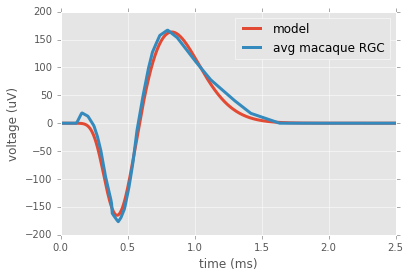

In [351]:
tsample = 0.005 / 1000
t, filt = pred_response(res.x, 166.61, 176.46, tsample * 1000)
plt.plot(t, filt, linewidth=3, label='model')
plt.plot(t, interp_data(t), linewidth=3, label='avg macaque RGC')
plt.xlabel('time (ms)')
plt.ylabel('voltage (uV)')
plt.legend()
plt.savefig('rgc_impulse.png')

In [71]:
import pulse2percept.electrode2currentmap as e2cm
from scipy.signal import fftconvolve

In [360]:
t, filt = pred_response(res.x, 0.5, 1.0, tsample * 1000)

In [366]:
filt /= np.trapz(np.abs(filt), dx=tsample)

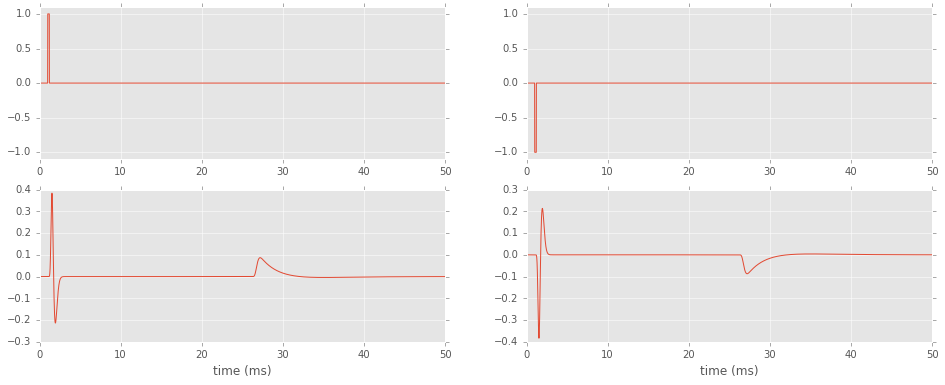

In [370]:
plt.figure(figsize=(16, 6))

dur = 0.05
delay = 1.0 / 1000
pdur = 0.2 / 1000

for i, ptype in enumerate(['cathodic', 'anodic']):
    t = np.arange(0, dur, tsample)
    plt.subplot(2, 2, i + 1)
    pt = e2cm.get_monophasic_pulse(ptype, pdur, tsample=tsample, delay_dur=delay, stim_dur=dur)
    plt.plot(t * 1000, -pt)
    plt.ylim(-1.1, 1.1)
    
    plt.subplot(2, 2, i + 3)
    pt_resp = tsample * fftconvolve(filt, pt)[:pt.size]

    tau_bp = 3.0 / 1000
    tbp = np.arange(0, 10 * tau_bp, tsample)
    bp_gamma = np.concatenate((np.zeros(5000), e2cm.gamma(2, tau_bp, tbp)))
    bi_resp = tsample * fftconvolve(bp_gamma, pt)[:pt.size]
    bi_resp = tsample * fftconvolve(filt, bi_resp)[:pt.size]
    
    plt.plot(t * 1000, np.maximum(-100, pt_resp + 20 * bi_resp))
#     plt.ylim(-0.0002, 0.0002)
    plt.xlabel('time (ms)')

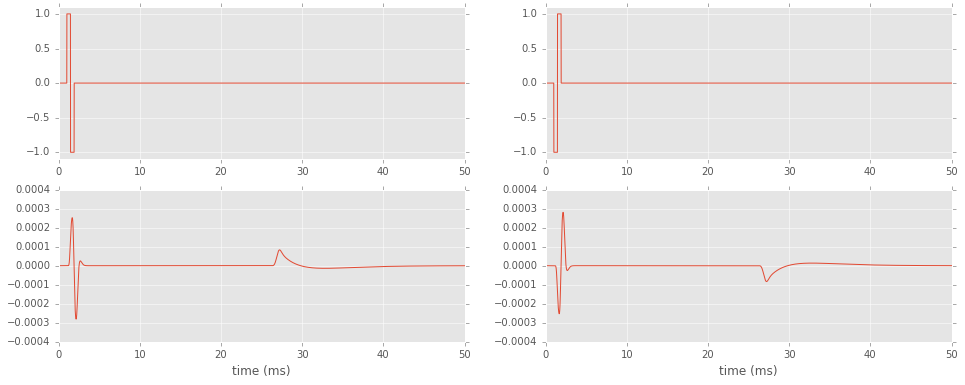

In [320]:
plt.figure(figsize=(16, 6))

dur = 0.05
delay = 1.0 / 1000
pdur = 1.0 / 1000
idur = 0 # 0.04 / 1000

for i, ptype in enumerate(['cathodicfirst', 'anodicfirst']):
    t = np.arange(0, dur, tsample)
    plt.subplot(2, 2, i + 1)
    pt = e2cm.Psycho2Pulsetrain(tsample, 1, 1, dur=dur, delay=delay, interphase_dur=idur, pulsetype=ptype)
    plt.plot(t * 1000, -pt.data)
    plt.ylim(-1.1, 1.1)
    
    plt.subplot(2, 2, i + 3)
    pt_resp = tsample * fftconvolve(filt, pt.data)[:pt.data.size]

    tau_bp = 3.0 / 1000
    tbp = np.arange(0, 10 * tau_bp, tsample)
    bp_gamma = np.concatenate((np.zeros(5000), e2cm.gamma(2, tau_bp, tbp)))
    bi_resp = tsample * fftconvolve(bp_gamma, pt.data)[:pt.data.size]
    bi_resp = tsample * fftconvolve(filt, bi_resp)[:pt.data.size]
    
    plt.plot(t * 1000, np.maximum(-100, pt_resp + 20.0 * bi_resp))
    plt.ylim(-0.0004, 0.0004)
    plt.xlabel('time (ms)')